In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from bidi import algorithm as bidialg
import warnings

# התעלמות מכל ההתראות
warnings.filterwarnings("ignore")
#pd.set_option('display.max_rows', None)

In [5]:
panel_05_df = pd.read_csv("inputdata/Panel_05.csv")
#panel_05_df = panel_05_df[panel_05_df['YEAR'] != 2013]

panel_05_df


,YEAR,PRACTICE_CODE,POSTCODE,AST_Prevalence,COPD_Prevalence,COPD002(percent),COPD003(percent),COPD004(percent),COPD005(percent),COPD007(percent),...,Weighted_Houses_Median_size_of_private_outdoor_space_(m2),Weighted_Flats_Percentage_of_adresses_with_private_outdoor_space,Weighted_Flats_Average_size_of_private_outdoor_space_(m2),Weighted_Flats_Average_number_of_flats_sharing_a_garden,Weighted_Total_Percentage_of_adresses_with_private_outdoor_space,SMOK001_Underlying_achievement_net_of_exceptions(per_cent),SMOK002_Underlying_achievement_net_of_exceptions(per_cent),SMOK004_Underlying_achievement_net_of_exceptions(per_cent),SMOK005_Underlying_achievement_net_of_exceptions(per_cent),Obesity_Prevalence(per_cent)
0,2019,E83027,NW11 9AY,2.94,0.96,92.59,96.88,94.74,100.00,100.00,...,224.0,0.66,237.0,4.00,0.81,NaN,96.300000,90.300000,99.500000,5.600000
1,2019,E83044,EN5 1QH,3.89,1.80,93.40,93.15,94.56,98.44,85.93,...,240.0,0.64,337.0,5.00,0.83,NaN,95.709382,93.923241,99.519231,7.424851
2,2019,E83600,NW11 7NP,2.55,0.22,66.67,100.00,100.00,100.00,100.00,...,214.0,0.63,245.0,4.00,0.81,NaN,97.364568,85.929648,100.000000,3.004292
3,2019,E83621,N11 1EY,5.49,1.01,83.93,96.34,92.59,100.00,92.11,...,187.0,0.65,271.0,4.00,0.88,NaN,96.492986,91.026919,97.524752,11.060915
4,2019,E83637,NW9 6DJ,2.92,0.55,81.25,91.67,87.50,100.00,93.48,...,143.0,0.63,257.0,19.00,0.74,NaN,96.302521,91.330798,98.657718,7.760191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52697,2013,J82008,SO30 3PY,6.55,1.43,NaN,NaN,NaN,NaN,NaN,...,211.0,0.70,358.0,3.00,0.93,NaN,NaN,NaN,NaN,NaN
52698,2013,J82036,GU32 1LR,5.13,1.15,NaN,NaN,NaN,NaN,NaN,...,439.0,0.73,614.0,0.68,0.89,NaN,NaN,NaN,NaN,NaN
52699,2013,J82214,RG28 7AE,7.74,1.34,NaN,NaN,NaN,NaN,NaN,...,311.0,0.72,488.0,1.00,0.88,NaN,NaN,NaN,NaN,NaN
52700,2013,J82034,PO17 5GU,7.59,1.38,NaN,NaN,NaN,NaN,NaN,...,345.0,0.62,885.0,2.00,0.84,NaN,NaN,NaN,NaN,NaN


In [7]:
columns_to_drop = ['YEAR','PRACTICE_CODE','POSTCODE','SMOK001_Underlying_achievement_net_of_exceptions(per_cent)']    
df_after_drop = panel_05_df.drop(columns=columns_to_drop)
df_after_drop.isnull().sum()

AST_Prevalence                                                         1
COPD_Prevalence                                                       10
COPD002(percent)                                                    8073
COPD003(percent)                                                    8043
COPD004(percent)                                                    8043
                                                                    ... 
Weighted_Total_Percentage_of_adresses_with_private_outdoor_space     464
SMOK002_Underlying_achievement_net_of_exceptions(per_cent)          8121
SMOK004_Underlying_achievement_net_of_exceptions(per_cent)          8129
SMOK005_Underlying_achievement_net_of_exceptions(per_cent)          8140
Obesity_Prevalence(per_cent)                                        8127
Length: 82, dtype: int64

### פונקציה - נתונים סטטיסיטים וחריגים

In [19]:
import pandas as pd

def make_stat_and_detect_outliers(df, threshold):
    # הגדרת רשימה ריקה לאחסון התוצאות
    combined_info = []
    
    # לולאה על כל עמודה ב-DataFrame
    for column in df.columns:
        # חישוב מספר הערכים החסרים
        missing_values = df[column].isnull().sum()
        
        # חישוב סטטיסטיקות בסיסיות
        max_value = df[column].max()
        min_value = df[column].min()
        mean_value = df[column].mean()
        median_value = df[column].median()
        q1_value = df[column].quantile(0.25)
        q3_value = df[column].quantile(0.75)
        count_zeros = (df[column] == 0).sum()
        
        # חישוב IQR
        IQR = q3_value - q1_value
        lower_bound_iqr = q1_value - threshold * IQR
        upper_bound_iqr = q3_value + threshold * IQR
        num_outliers_iqr = ((df[column] < lower_bound_iqr) | (df[column] > upper_bound_iqr)).sum()
        percent_outliers_iqr = num_outliers_iqr / len(df) * 100
        
        # חישוב סטיית תקן
        stdev = df[column].std()
        lower_bound_stdev = mean_value - threshold * stdev
        upper_bound_stdev = mean_value + threshold * stdev
        num_outliers_stdev = ((df[column] < lower_bound_stdev) | (df[column] > upper_bound_stdev)).sum()
        percent_outliers_stdev = num_outliers_stdev / len(df) * 100
        
        # הוספת התוצאות לרשימה
        combined_info.append({
            'Column Name': column,
            'Max': max_value,
            'Min': min_value,
            'Mean': mean_value,
            'Median': median_value,
            'Q1': q1_value,
            'Q3': q3_value,
            'Count of Zeros': count_zeros,
            'NULL Values': missing_values,
            '|': '|',
            'Lower Bound IQR': lower_bound_iqr,
            'Upper Bound IQR': upper_bound_iqr,
            'Number of Outliers IQR': num_outliers_iqr,
            'Percent of Outliers IQR': percent_outliers_iqr,
            'Lower Bound STDEV': lower_bound_stdev,
            'Upper Bound STDEV': upper_bound_stdev,
            'Number of Outliers STDEV': num_outliers_stdev,
            'Percent of Outliers STDEV': percent_outliers_stdev
        })
    
    # יצירת DataFrame חדש עבור התוצאות המשולבות
    combined_df = pd.DataFrame(combined_info)
    
    return combined_df


In [111]:
threshold = 3
outliers_df = make_stat_and_detect_outliers(df_after_drop, threshold)

In [113]:
# מיון לפי אחוז החריגים לפי IQR בסדר יורד
outliers_sorted_iqr = outliers_df.sort_values(by='Percent of Outliers IQR', ascending=False)
# מיון לפי אחוז החריגים לפי STDEV בסדר יורד
outliers_sorted_stdev = outliers_df.sort_values(by='Percent of Outliers STDEV', ascending=False)
# הצגת התוצאה הממוינת
outliers_sorted_stdev


,Column Name,Max,Min,Mean,Median,Q1,Q3,Count of Zeros,NULL Values,|,Lower Bound IQR,Upper Bound IQR,Number of Outliers IQR,Percent of Outliers IQR,Lower Bound STDEV,Upper Bound STDEV,Number of Outliers STDEV,Percent of Outliers STDEV
61,Weighted_ParksOnly_Average_distance_to_nearest...,13929.00,111.000000,932.932214,614.000000,425.000000,980.000000,0,464,|,-1240.000000,2645.000000,3045,5.777769,-2028.109915,3893.974343,1405,2.665933
70,Weighted_ParksAndPlayingFields_Number_of_built...,1.00,0.030000,0.941167,0.980000,0.930000,1.000000,0,464,|,0.720000,1.210000,2394,4.542522,0.633453,1.248880,1335,2.533111
77,Weighted_Total_Percentage_of_adresses_with_pri...,0.98,0.140000,0.888324,0.910000,0.870000,0.930000,0,464,|,0.690000,1.110000,1300,2.466700,0.663553,1.113095,1137,2.157413
80,SMOK005_Underlying_achievement_net_of_exceptio...,100.00,3.157895,95.898541,97.894737,96.341463,99.367089,0,8140,|,87.264588,108.443964,3556,6.747372,74.587933,117.209148,1129,2.142234
72,Weighted_Houses_Average_size_of_private_outdoo...,4152.00,23.000000,294.121387,228.000000,170.000000,345.000000,0,464,|,-355.000000,870.000000,1269,2.407878,-340.315381,928.558155,1009,1.914538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,Weighted_Index_of_Multiple_Deprivation_(IMD),31665.00,1013.000000,15224.194858,14806.000000,9610.000000,20845.000000,0,464,|,-24095.000000,54550.000000,0,0.000000,-5528.293415,35976.683131,0,0.000000
58,Weighted_Crime,32542.00,998.000000,15463.046212,14847.000000,9600.000000,21188.000000,0,464,|,-25164.000000,55952.000000,0,0.000000,-6033.275221,36959.367644,0,0.000000
59,Weighted_Barriers_to_Housing_and_Services,31825.00,183.000000,15793.332383,16403.500000,10876.000000,21086.000000,0,464,|,-19754.000000,51716.000000,0,0.000000,-4812.886135,36399.550900,0,0.000000
60,Weighted_Living_Environment,32294.00,200.000000,15282.292450,15175.000000,9545.000000,20748.000000,0,464,|,-24064.000000,54357.000000,0,0.000000,-5956.353426,36520.938326,0,0.000000


In [ ]:
top_one_columns_IQR_list = outliers_sorted_iqr['Column Name'].head(1).tolist()
top1_befor_IQR_df = df_after_drop[top_one_columns_IQR_list]
Clean_outliers_df_1 = Clean_outliers(top1_befor_IQR_df,'IQR',2.5)
outliers_df_new = make_stat_and_detect_outliers(Clean_outliers_df_1, 2.5)
outliers_df_new


In [109]:
befor_top1_IQR =  make_stat_and_detect_outliers(top1_befor_IQR_df, 2.5)
after_top1_IQR = make_stat_and_detect_outliers(Clean_outliers_df_1, 2.5)

comparison_df = pd.concat([befor_top1_IQR, after_top1_IQR], keys=['Before Cleaning', 'After Cleaning'])
name = ['Column Name', 'Max', 'Min', 'Mean', 'Median', 'Q1', 'Q3',
       'Lower Bound IQR','Upper Bound IQR', 'Number of Outliers IQR', 'Percent of Outliers IQR']
comparison_df_name = comparison_df[name]

comparison_df_name

,,Column Name,Max,Min,Mean,Median,Q1,Q3,Lower Bound IQR,Upper Bound IQR,Number of Outliers IQR,Percent of Outliers IQR
Before Cleaning,0,SMOK005_Underlying_achievement_net_of_exceptio...,100.0,3.157895,95.898541,97.894737,96.341463,99.367089,88.777400,106.931152,4121,7.819438
After Cleaning,0,SMOK005_Underlying_achievement_net_of_exceptio...,100.0,88.777555,97.754526,98.181818,96.825397,99.484536,90.177549,106.132384,622,1.280336


In [147]:
top_one_columns_std_list = outliers_sorted_stdev['Column Name'].head(1).tolist()
top1_befor_std_df = df_after_drop[top_one_columns_std_list]
Clean_outliers_df_2 = Clean_outliers(top1_befor_std_df,'StdDev',3)
outliers_df_new_std = make_stat_and_detect_outliers(Clean_outliers_df_1, 3)
outliers_df_new_std

Clean outliers method:  StdDev
Threshold: 3
Number of outliers removed: 1405
Number of rows in the cleaned dataset: 51297



,Column Name,Max,Min,Mean,Median,Q1,Q3,Count of Zeros,NULL Values,|,Lower Bound IQR,Upper Bound IQR,Number of Outliers IQR,Percent of Outliers IQR,Lower Bound STDEV,Upper Bound STDEV,Number of Outliers STDEV,Percent of Outliers STDEV
0,Weighted_ParksOnly_Average_distance_to_nearest...,2365.0,111.0,716.314361,586.0,415.0,868.0,0,464,|,-944.0,2227.0,435,0.884128,-589.514202,2022.142923,1106,2.247922


In [149]:
befor_top1_std =  make_stat_and_detect_outliers(top1_befor_std_df, 3)
after_top1_dtd = make_stat_and_detect_outliers(Clean_outliers_df_2, 3)

comparison_df = pd.concat([befor_top1_IQR, after_top1_IQR], keys=['Before Cleaning', 'After Cleaning'])
name = ['Column Name', 'Max', 'Min', 'Mean', 'Median', 'Q1', 'Q3',
       'Lower Bound IQR','Upper Bound IQR', 'Number of Outliers IQR', 'Percent of Outliers IQR']
comparison_df_name = comparison_df[name]

comparison_df

,,Column Name,Max,Min,Mean,Median,Q1,Q3,Count of Zeros,NULL Values,|,Lower Bound IQR,Upper Bound IQR,Number of Outliers IQR,Percent of Outliers IQR,Lower Bound STDEV,Upper Bound STDEV,Number of Outliers STDEV,Percent of Outliers STDEV
Before Cleaning,0,SMOK005_Underlying_achievement_net_of_exceptio...,100.0,3.157895,95.898541,97.894737,96.341463,99.367089,0,8140,|,88.777400,106.931152,4121,7.819438,78.139701,113.657380,1545,2.931578
After Cleaning,0,SMOK005_Underlying_achievement_net_of_exceptio...,100.0,88.777555,97.754526,98.181818,96.825397,99.484536,0,8140,|,90.177549,106.132384,622,1.280336,92.144996,103.364056,1686,3.470493


#  בדיקה עם ערך ריק במקום אפס

תבונה : החלפת האפסים בתא ריק לא משנה על אחוז החריגים באופן משמעותי

In [ ]:
#מי הערך עם הכי הרבה אפסים
outliers_sorted_by_zero_df = outliers_df.sort_values(by='Count of Zeros', ascending=False)


In [ ]:
#החלפה אפס בערך ריק
df_after_drop_replaced = df_after_drop.replace(0, np.nan)

In [ ]:
threshold = 2.5
outliers_after_replaced_df = make_stat_and_detect_outliers(df_after_drop_replaced, threshold)
outliers_after_replaced_iqr_df = outliers_after_replaced_df.sort_values(by='Percent of Outliers IQR', ascending=False)
# מיון לפי אחוז החריגים לפי STDEV בסדר יורד
outliers_after_replaced_stdev_df = outliers_after_replaced_df.sort_values(by='Percent of Outliers STDEV', ascending=False)
# הצגת התוצאה הממוינת
outliers_after_replaced_iqr_df.head(3)

In [ ]:
row_before = outliers_df.loc[outliers_df['Column Name'] == outliers_sorted_by_zero_df.iloc[0, 0]].copy()
row_after = outliers_after_replaced_df.loc[outliers_df['Column Name'] == outliers_sorted_by_zero_df.iloc[0, 0]].copy()

# הוספת עמודה "סטטוס" לציון אם זה לפני או אחרי ההחלפה
row_before.loc[:, 'Status'] = 'Before'
row_after.loc[:, 'Status'] = 'After'

# איחוד השורות לקובץ אחד
rows_combined = pd.concat([row_before, row_after])
rows_combined

# יצירה של גרפים

In [ ]:
threshold = 1.5  # ערך הסף
method='IQR'
top_three_columns_list = outliers_sorted_iqr['Column Name'].head(3).tolist()
top3_df = df_after_drop[top_three_columns_list]
top3_df

### boxplots

In [ ]:
"""def plot_boxplots(df, method, threshold, num_plots=3, figsize=(15, 5), color_palette='Set2'):
    outliers_df = make_stat_and_detect_outliers(df, threshold)
    
    # מיון לפי אחוז החריגים הגבוה ביותר לפי השיטה הנבחרת
    if method == 'IQR':
        outliers_sorted = outliers_df.sort_values(by='Percent of Outliers IQR', ascending=False)
    elif method == 'stdev':
        outliers_sorted = outliers_df.sort_values(by='Percent of Outliers STDEV', ascending=False)
    else:
        raise ValueError("Unsupported method. Choose 'IQR' or 'stdev'.")
    
    # בחירת העמודות עם האחוזים הגבוהים ביותר
    top_columns = outliers_sorted.head(num_plots)['Column Name']
    
    # יצירת גרפים של בוקס פלוט
    fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=figsize)
    
    # בודק אם יש צורך להגדיר פלטת צבעים אחרת
    if isinstance(color_palette, str):
        color_palette = sns.color_palette(color_palette)
    
    for i, column in enumerate(top_columns):
        sns.boxplot(ax=axes[i], data=df[column], color=color_palette[i])
        
        # הוספת הערות לגרף עם גבולות, ממוצע וחציון
        upper_bound_iqr = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Upper Bound IQR'].values[0]
        lower_bound_iqr = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Lower Bound IQR'].values[0]
        mean_value = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Mean'].values[0]
        
        axes[i].axhline(upper_bound_iqr, linestyle='--', color='red', label=f'Upper Bound IQR: {upper_bound_iqr:.2f}')
        axes[i].axhline(lower_bound_iqr, linestyle='--', color='blue', label=f'Lower Bound IQR: {lower_bound_iqr:.2f}')
        axes[i].axhline(mean_value, linestyle='-', color='green', label=f'Mean: {mean_value:.2f}')
        
        axes[i].set_title(f'Boxplot of {column}')
        axes[i].set_ylabel(column)
        axes[i].legend(loc='center right', prop={'size': 8}, title='Values:')
    
    plt.tight_layout()
    plt.show()"""

In [ ]:

"plot_boxplots(top3_df,method, threshold=1.5)"

### היסטוגרמה

In [ ]:
"""import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histograms_std_and_regular(df, method, threshold, num_plots=3, figsize=(15, 10), color_palette='Set2'):
    outliers_df = make_stat_and_detect_outliers(df, threshold)
    
    if method == 'IQR':
        outliers_sorted = outliers_df.sort_values(by='Percent of Outliers IQR', ascending=False)
    elif method == 'stdev':
        outliers_sorted = outliers_df.sort_values(by='Percent of Outliers STDEV', ascending=False)
    else:
        raise ValueError("שיטה לא נתמכת. בחר 'IQR' או 'stdev'.")
    
    top_columns = outliers_sorted.head(num_plots)['Column Name']
    
    fig, axes = plt.subplots(nrows=2, ncols=num_plots, figsize=figsize)
    
    if isinstance(color_palette, str):
        color_palette = sns.color_palette(color_palette)
    
    for i, column in enumerate(top_columns):
        mean = df[column].mean()
        std = df[column].std()
        data_in_std = (df[column] - mean) / std
        
        


         # היסטוגרמה רגילה
        sns.histplot(df[column], kde=True, color=color_palette[i], ax=axes[0, i])
        axes[0, i].set_title(f'Histogram of {column} ')
        axes[0, i].set_xlabel(column)
        axes[0, i].set_ylabel(bidialg.get_display('תדירות'))
        axes[0, i].grid(True)
        
        upper_bound = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Upper Bound IQR'].values[0]
        lower_bound = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Lower Bound IQR'].values[0]
        
        axes[0, i].axvline(upper_bound, linestyle='--', color='red')
        axes[0, i].axvline(lower_bound, linestyle='--', color='blue')
        axes[0, i].axvline(mean, linestyle='-', color='green')
        
        # התאמת גבולות של ציר Y
        y_max = 2600
        axes[0, i].set_ylim(0, y_max)
        axes[0, i].set_yticks(np.arange(0, y_max + 1, y_max / 5))
        
        # היסטוגרמה של סטיות תקן
        sns.histplot(data_in_std, kde=True, color=color_palette[i], ax=axes[1, i])
        #axes[1, i].set_title(f'Histogram of {column}\n(Standardized)')
        axes[1, i].set_xlabel('Standard Deviations from Mean')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].set_xlim(-4, 4)
        axes[1, i].set_xticks(range(-4, 5))
        axes[1, i].grid(True)
        
        upper_bound_std = (outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Upper Bound IQR'].values[0] - mean) / std
        lower_bound_std = (outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Lower Bound IQR'].values[0] - mean) / std
        
        axes[1, i].axvline(upper_bound_std, linestyle='--', color='red')
        axes[1, i].axvline(lower_bound_std, linestyle='--', color='blue')
        axes[1, i].axvline(0, linestyle='-', color='green')
        
        # התאמת גבולות של ציר Y
        y_max = 2600
        axes[1, i].set_ylim(0, y_max)
        axes[1, i].set_yticks(np.arange(0, y_max + 1, y_max / 5))
        
               # הוספת טקסט לגרפים
        axes[0, i].text(0.5, 1.1, column[0:5], horizontalalignment='center', verticalalignment='center', transform=axes[0, i].transAxes, fontsize=16, fontweight='bold')


    plt.tight_layout()
    plt.show()


"""

In [ ]:
"""plot_histograms_std_and_regular(df_after_drop, method, threshold)"""

### כולם יחד

In [ ]:

def plot_histograms_std_and_regular(df, method, threshold, colomnHebrName, num_plots=3, figsize=(15, 15), color_palette='Set2'):
    outliers_df = make_stat_and_detect_outliers(df, threshold)
    
    if method == 'IQR':
        outliers_sorted = outliers_df.sort_values(by='Percent of Outliers IQR', ascending=False)
    elif method == 'stdev':
        outliers_sorted = outliers_df.sort_values(by='Percent of Outliers STDEV', ascending=False)
    else:
        raise ValueError(bidialg.get_display("שיטה לא נתמכת. בחר 'IQR' או 'stdev'."))
    
    top_columns = outliers_sorted.head(num_plots)['Column Name']
    
    fig, axes = plt.subplots(nrows=3, ncols=num_plots, figsize=figsize)
    
    if isinstance(color_palette, str):
        color_palette = sns.color_palette(color_palette)
    
    for i, column in enumerate(top_columns):
        mean = df[column].mean()
        std = df[column].std()
        data_in_std = (df[column] - mean) / std
        
        # בוקס פלוט
        sns.boxplot(ax=axes[0, i], data=df[column], color=color_palette[i])
        
        upper_bound_iqr = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Upper Bound IQR'].values[0]
        lower_bound_iqr = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Lower Bound IQR'].values[0]
        mean_value = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Mean'].values[0]
        
        axes[0, i].axhline(upper_bound_iqr, linestyle='--', color='red', label=bidialg.get_display(f'גבול עליון IQR: {upper_bound_iqr:.2f}'))
        axes[0, i].axhline(lower_bound_iqr, linestyle='--', color='blue', label=bidialg.get_display(f'גבול תחתון IQR: {lower_bound_iqr:.2f}'))
        axes[0, i].axhline(mean_value, linestyle='-', color='green', label=bidialg.get_display(f'ממוצע: {mean_value:.2f}'))
        
        axes[0, i].set_title(bidialg.get_display("בוקס פלוט"))
        axes[0, i].set_ylabel(bidialg.get_display("ערכים"))
        axes[0, i].legend(loc='center right', prop={'size': 8}, title=bidialg.get_display('מקרא:'))
        
        # היסטוגרמה רגילה
        sns.histplot(df[column], kde=True, color=color_palette[i], ax=axes[1, i])
        axes[1, i].set_title(bidialg.get_display("היסטוגרמה"))
        axes[1, i].set_ylabel(bidialg.get_display("תדירות"))
        axes[1, i].set_xlabel(bidialg.get_display("ערכים"))

        axes[1, i].grid(True)
        
        upper_bound = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Upper Bound IQR'].values[0]
        lower_bound = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Lower Bound IQR'].values[0]
        
        axes[1, i].axvline(upper_bound, linestyle='--', color='red', label=bidialg.get_display(f'גבול עליון: {upper_bound:.2f}'))
        axes[1, i].axvline(lower_bound, linestyle='--', color='blue', label=bidialg.get_display(f'גבול תחתון: {lower_bound:.2f}'))
        axes[1, i].axvline(mean, linestyle='-', color='green', label=bidialg.get_display(f'ממוצע: {mean:.2f}'))
        
        axes[1, i].set_ylim(0, 2600)
        axes[1, i].set_yticks(np.arange(0, 2601, 520))
        axes[1, i].legend(loc='upper right', prop={'size': 8}, title=bidialg.get_display('מקרא:'))

        # היסטוגרמה של סטיות תקן
        sns.histplot(data_in_std, kde=True, color=color_palette[i], ax=axes[2, i])
        axes[2, i].set_xlabel(bidialg.get_display("סטיות תקן"))
        axes[2, i].set_ylabel(bidialg.get_display("תדירות"))
        axes[2, i].set_xlim(-4, 4)
        axes[2, i].set_xticks(range(-4, 5))
        axes[2, i].grid(True)
        
        upper_bound_std = (outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Upper Bound IQR'].values[0] - mean) / std
        lower_bound_std = (outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Lower Bound IQR'].values[0] - mean) / std
        
        axes[2, i].axvline(upper_bound_std, linestyle='--', color='red', label=bidialg.get_display(f'גבול עליון: {upper_bound_std:.2f}'))
        axes[2, i].axvline(lower_bound_std, linestyle='--', color='blue', label=bidialg.get_display(f'גבול תחתון: {lower_bound_std:.2f}'))
        axes[2, i].axvline(0, linestyle='-', color='green')
        
        axes[2, i].set_ylim(0, 2600)
        axes[2, i].set_yticks(np.arange(0, 2601, 520))
        axes[2, i].legend(loc='upper right', prop={'size': 8}, title=bidialg.get_display('מקרא:'))
        
        # הוספת טקסט לגרפים
        axes[0, i].text(0.5, 1.1, bidialg.get_display(colomnHebrName[i]), horizontalalignment='center', verticalalignment='center', transform=axes[0, i].transAxes, fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()


In [ ]:
colomnHebrName =["אינדקטור COPD007"
 ,"SMOK007 אינדקטור",
 "מרחק ממוצע מהפארק הכי קרוב (מטר)"]    

In [ ]:
plot_histograms_std_and_regular(top3_df, method, threshold,colomnHebrName)

## לאחר ניכוי חריגים

In [39]:
def Clean_outliers( df , method_outliers, threshold) :
   
    # Select only numeric columns for outlier detection
    numeric_df = df.select_dtypes(include=[np.number])

    if method_outliers == 'IQR':
        Q1 = numeric_df.quantile(0.25)
        Q3 = numeric_df.quantile(0.75)
        IQR = Q3 - Q1
        filter_condition = ~((numeric_df < (Q1 - threshold * IQR)) | (numeric_df > (Q3 + threshold * IQR))).any(axis=1)
    elif method_outliers == 'StdDev':
        mean = numeric_df.mean()
        std_dev = numeric_df.std()
        filter_condition = ~((numeric_df < (mean - threshold * std_dev)) | (numeric_df > (mean + threshold * std_dev))).any(axis=1)
    else:
        raise ValueError("Invalid method. Choose 'IQR', 'Z-score', or 'StdDev'.")

    # Filter the original dataframe
    df_clean = df[filter_condition]

    # Calculate the number of outliers removed
    num_outliers_removed = len(df) - len(df_clean)
    num_remaining = len(df_clean)
    
    print("Clean outliers method: ",method_outliers )
    print("Threshold:",threshold )
    print(f"Number of outliers removed: {num_outliers_removed}")
    print(f"Number of rows in the cleaned dataset: {num_remaining}\n")

    return df_clean

In [ ]:
Clean_outliers_df = Clean_outliers(top3_df,method,threshold=10)
Clean_outliers_df

In [ ]:
def plot_three_histograms(df, colomnHebrName, threshold=1.5, figsize=(15, 15), color_palette='Set2'):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=figsize)
    
    if isinstance(color_palette, str):
        color_palette = sns.color_palette(color_palette)
    
    for i, column in enumerate(df.columns[:3]):
        mean = df[column].mean()
        std = df[column].std()
        data_in_std = (df[column] - mean) / std
        
        # בוקס פלוט
        sns.boxplot(ax=axes[0, i], data=df[column], color=color_palette[i])
        
        upper_bound_iqr = df[column].quantile(0.75) + threshold * (df[column].quantile(0.75) - df[column].quantile(0.25))
        lower_bound_iqr = df[column].quantile(0.25) - threshold * (df[column].quantile(0.75) - df[column].quantile(0.25))
        
        axes[0, i].axhline(upper_bound_iqr, linestyle='--', color='red', label=bidialg.get_display(f'גבול עליון IQR: {upper_bound_iqr:.2f}'))
        axes[0, i].axhline(lower_bound_iqr, linestyle='--', color='blue', label=bidialg.get_display(f'גבול תחתון IQR: {lower_bound_iqr:.2f}'))
        axes[0, i].axhline(mean, linestyle='-', color='green', label=bidialg.get_display(f'ממוצע: {mean:.2f}'))
        
        axes[0, i].set_title(bidialg.get_display("בוקס פלוט"))
        axes[0, i].set_ylabel(bidialg.get_display("ערכים"))
        axes[0, i].legend(loc='center right', prop={'size': 8}, title=bidialg.get_display('מקרא:'))
        
        # היסטוגרמה רגילה
        sns.histplot(df[column], kde=True, color=color_palette[i], ax=axes[1, i])
        axes[1, i].set_title(bidialg.get_display("היסטוגרמה"))
        axes[1, i].set_ylabel(bidialg.get_display("תדירות"))
        axes[1, i].set_xlabel(bidialg.get_display("ערכים"))

        axes[1, i].grid(True)
        
        axes[1, i].axvline(upper_bound_iqr, linestyle='--', color='red', label=bidialg.get_display(f'גבול עליון: {upper_bound_iqr:.2f}'))
        axes[1, i].axvline(lower_bound_iqr, linestyle='--', color='blue', label=bidialg.get_display(f'גבול תחתון: {lower_bound_iqr:.2f}'))
        axes[1, i].axvline(mean, linestyle='-', color='green', label=bidialg.get_display(f'ממוצע: {mean:.2f}'))
        
        axes[1, i].set_ylim(0, 2600)
        axes[1, i].set_yticks(np.arange(0, 2601, 520))
        axes[1, i].legend(loc='upper right', prop={'size': 8}, title=bidialg.get_display('מקרא:'))

        # היסטוגרמה של סטיות תקן
        sns.histplot(data_in_std, kde=True, color=color_palette[i], ax=axes[2, i])
        axes[2, i].set_xlabel(bidialg.get_display("סטיות תקן"))
        axes[2, i].set_ylabel(bidialg.get_display("תדירות"))
        axes[2, i].set_xlim(-4, 4)
        axes[2, i].set_xticks(range(-4, 5))
        axes[2, i].grid(True)
        
        axes[2, i].axvline((df[column].quantile(0.75) + threshold * (df[column].quantile(0.75) - df[column].quantile(0.25)) - mean) / std, linestyle='--', color='red', label=bidialg.get_display(f'גבול עליון: {(df[column].quantile(0.75) + threshold * (df[column].quantile(0.75) - df[column].quantile(0.25)) - mean) / std:.2f}'))
        axes[2, i].axvline((df[column].quantile(0.25) - threshold * (df[column].quantile(0.75) - df[column].quantile(0.25)) - mean) / std, linestyle='--', color='blue', label=bidialg.get_display(f'גבול תחתון: {(df[column].quantile(0.25) - threshold * (df[column].quantile(0.75) - df[column].quantile(0.25)) - mean) / std:.2f}'))
        axes[2, i].axvline(0, linestyle='-', color='green')
        
        axes[2, i].set_ylim(0, 2600)
        axes[2, i].set_yticks(np.arange(0, 2601, 520))
        axes[2, i].legend(loc='upper right', prop={'size': 8}, title=bidialg.get_display('מקרא:'))
        
        # הוספת טקסט לגרפים
        axes[0, i].text(0.5, 1.1, bidialg.get_display(colomnHebrName[i]), horizontalalignment='center', verticalalignment='center', transform=axes[0, i].transAxes, fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_three_histograms(top3_df,colomnHebrName)
plot_three_histograms(Clean_outliers_df,colomnHebrName)


# יצירה גרף של כולם

## IQR

In [ ]:
threshold = 2.5  # ערך הסף
method='IQR'
top_one_columns_list = outliers_sorted_iqr['Column Name'].head(1).tolist()
top1_befor_df = df_after_drop[top_three_columns_list]


In [ ]:
top1_after_df=  Clean_outliers(top1_befor_df , method, 2.5)


In [203]:
def plot_histograms_std_and_regular(df_before, df_after, colomnHebrName, threshold=2.5, figsize=(20, 24), color_palette='Set2'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=figsize)
    
   
    color_palette = sns.color_palette(color_palette)
    
    dfs = [df_before, df_after]
    titles = [bidialg.get_display("לפני ניכוי חריגים"), bidialg.get_display("אחרי ניכוי חריגים")]
    
    for j, df in enumerate(dfs):
        mean = df.iloc[:, 0].mean()
        std = df.iloc[:, 0].std()
        data_in_std = (df.iloc[:, 0] - mean) / std
        
        upper_bound_iqr = df.quantile(0.75).values[0] + threshold * (df.quantile(0.75).values[0] - df.quantile(0.25).values[0])
        lower_bound_iqr = df.quantile(0.25).values[0] - threshold * (df.quantile(0.75).values[0] - df.quantile(0.25).values[0])
        
        # בוקס פלוט
        sns.boxplot(ax=axes[0, j], data=df.iloc[:, 0], color=color_palette[j])
        axes[0, j].axhline(upper_bound_iqr, linestyle='--', color='red', label=bidialg.get_display(f'גבול עליון IQR: {upper_bound_iqr:.2f}'))
        axes[0, j].axhline(lower_bound_iqr, linestyle='--', color='blue', label=bidialg.get_display(f'גבול תחתון IQR: {lower_bound_iqr:.2f}'))
        axes[0, j].axhline(mean, linestyle='-', color='green', label=bidialg.get_display(f'ממוצע: {mean:.2f}'))
        axes[0, j].set_title(bidialg.get_display("בוקס פלוט"), fontsize=14)
        axes[0, j].set_ylabel(bidialg.get_display("ערכים"), fontsize=12)
        axes[0, j].legend(loc='best', prop={'size': 10}, title=bidialg.get_display('מקרא:'))
        
        # היסטוגרמה רגילה
        sns.histplot(df.iloc[:, 0], kde=True, bins=30, color=color_palette[j], ax=axes[1, j])
        axes[1, j].set_title(bidialg.get_display("היסטוגרמה"), fontsize=14)
        axes[1, j].set_ylabel(bidialg.get_display("תדירות"), fontsize=12)
        axes[1, j].set_xlabel(bidialg.get_display("ערכים"), fontsize=12)
        axes[1, j].grid(True, alpha=0.3)
        axes[1, j].axvline(upper_bound_iqr, linestyle='--', color='red', label=bidialg.get_display(f'גבול עליון: {upper_bound_iqr:.2f}'))
        axes[1, j].axvline(lower_bound_iqr, linestyle='--', color='blue', label=bidialg.get_display(f'גבול תחתון: {lower_bound_iqr:.2f}'))
        axes[1, j].axvline(mean, linestyle='-', color='green', label=bidialg.get_display(f'ממוצע: {mean:.2f}'))
        axes[1, j].legend(loc='best', prop={'size': 10}, title=bidialg.get_display('מקרא:'))

        # היסטוגרמה של סטיות תקן
        sns.histplot(data_in_std, kde=True, bins=30, color=color_palette[j], ax=axes[2, j])
        axes[2, j].set_xlabel(bidialg.get_display("סטיות תקן"), fontsize=12)
        axes[2, j].set_ylabel(bidialg.get_display("תדירות"), fontsize=12)
        axes[2, j].set_xlim(-4, 4)
        axes[2, j].set_xticks(range(-4, 5))
        axes[2, j].grid(True, alpha=0.3)
        upper_bound_std = (upper_bound_iqr - mean) / std
        lower_bound_std = (lower_bound_iqr - mean) / std
        axes[2, j].axvline(upper_bound_std, linestyle='--', color='red', label=bidialg.get_display(f'גבול עליון: {upper_bound_std:.2f}'))
        axes[2, j].axvline(lower_bound_std, linestyle='--', color='blue', label=bidialg.get_display(f'גבול תחתון: {lower_bound_std:.2f}'))
        axes[2, j].axvline(0, linestyle='-', color='green')
        axes[2, j].legend(loc='best', prop={'size': 10}, title=bidialg.get_display('מקרא:'))

        # הוספת טקסט לגרפים
        fig.text(0.5, 0.98, bidialg.get_display(colomnHebrName), ha='center', va='center', fontsize=18, fontweight='bold')
        axes[0, j].set_title(titles[j], fontsize=16, fontweight='bold', pad=20)

    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95], h_pad=3.0, w_pad=2.0)
    plt.show()

In [ ]:
colomnHebrName ="IQR |2.5 = ערך סף|SMOK007 אינדקטור"    

In [ ]:
plot_histograms_std_and_regular(top1_befor_df, top1_after_df, colomnHebrName)

## std

In [231]:
method='std'
top_one_columns_STD_list = outliers_sorted_stdev['Column Name'].head(1).tolist()
top1_befor_STD_df = df_after_drop[top_one_columns_STD_list]

colomnHebrName ="מרחק ממוצע מהפארק הקרוב (מטר) | ערך סף = 3 | StdDev"    
top1_after_std_df=  Clean_outliers(top1_befor_STD_df , 'StdDev', 3)

In [233]:
top1_after_std_df.columns

Index(['Weighted_ParksOnly_Average_distance_to_nearest_Park_or_Public_Garden_(m)'], dtype='object')

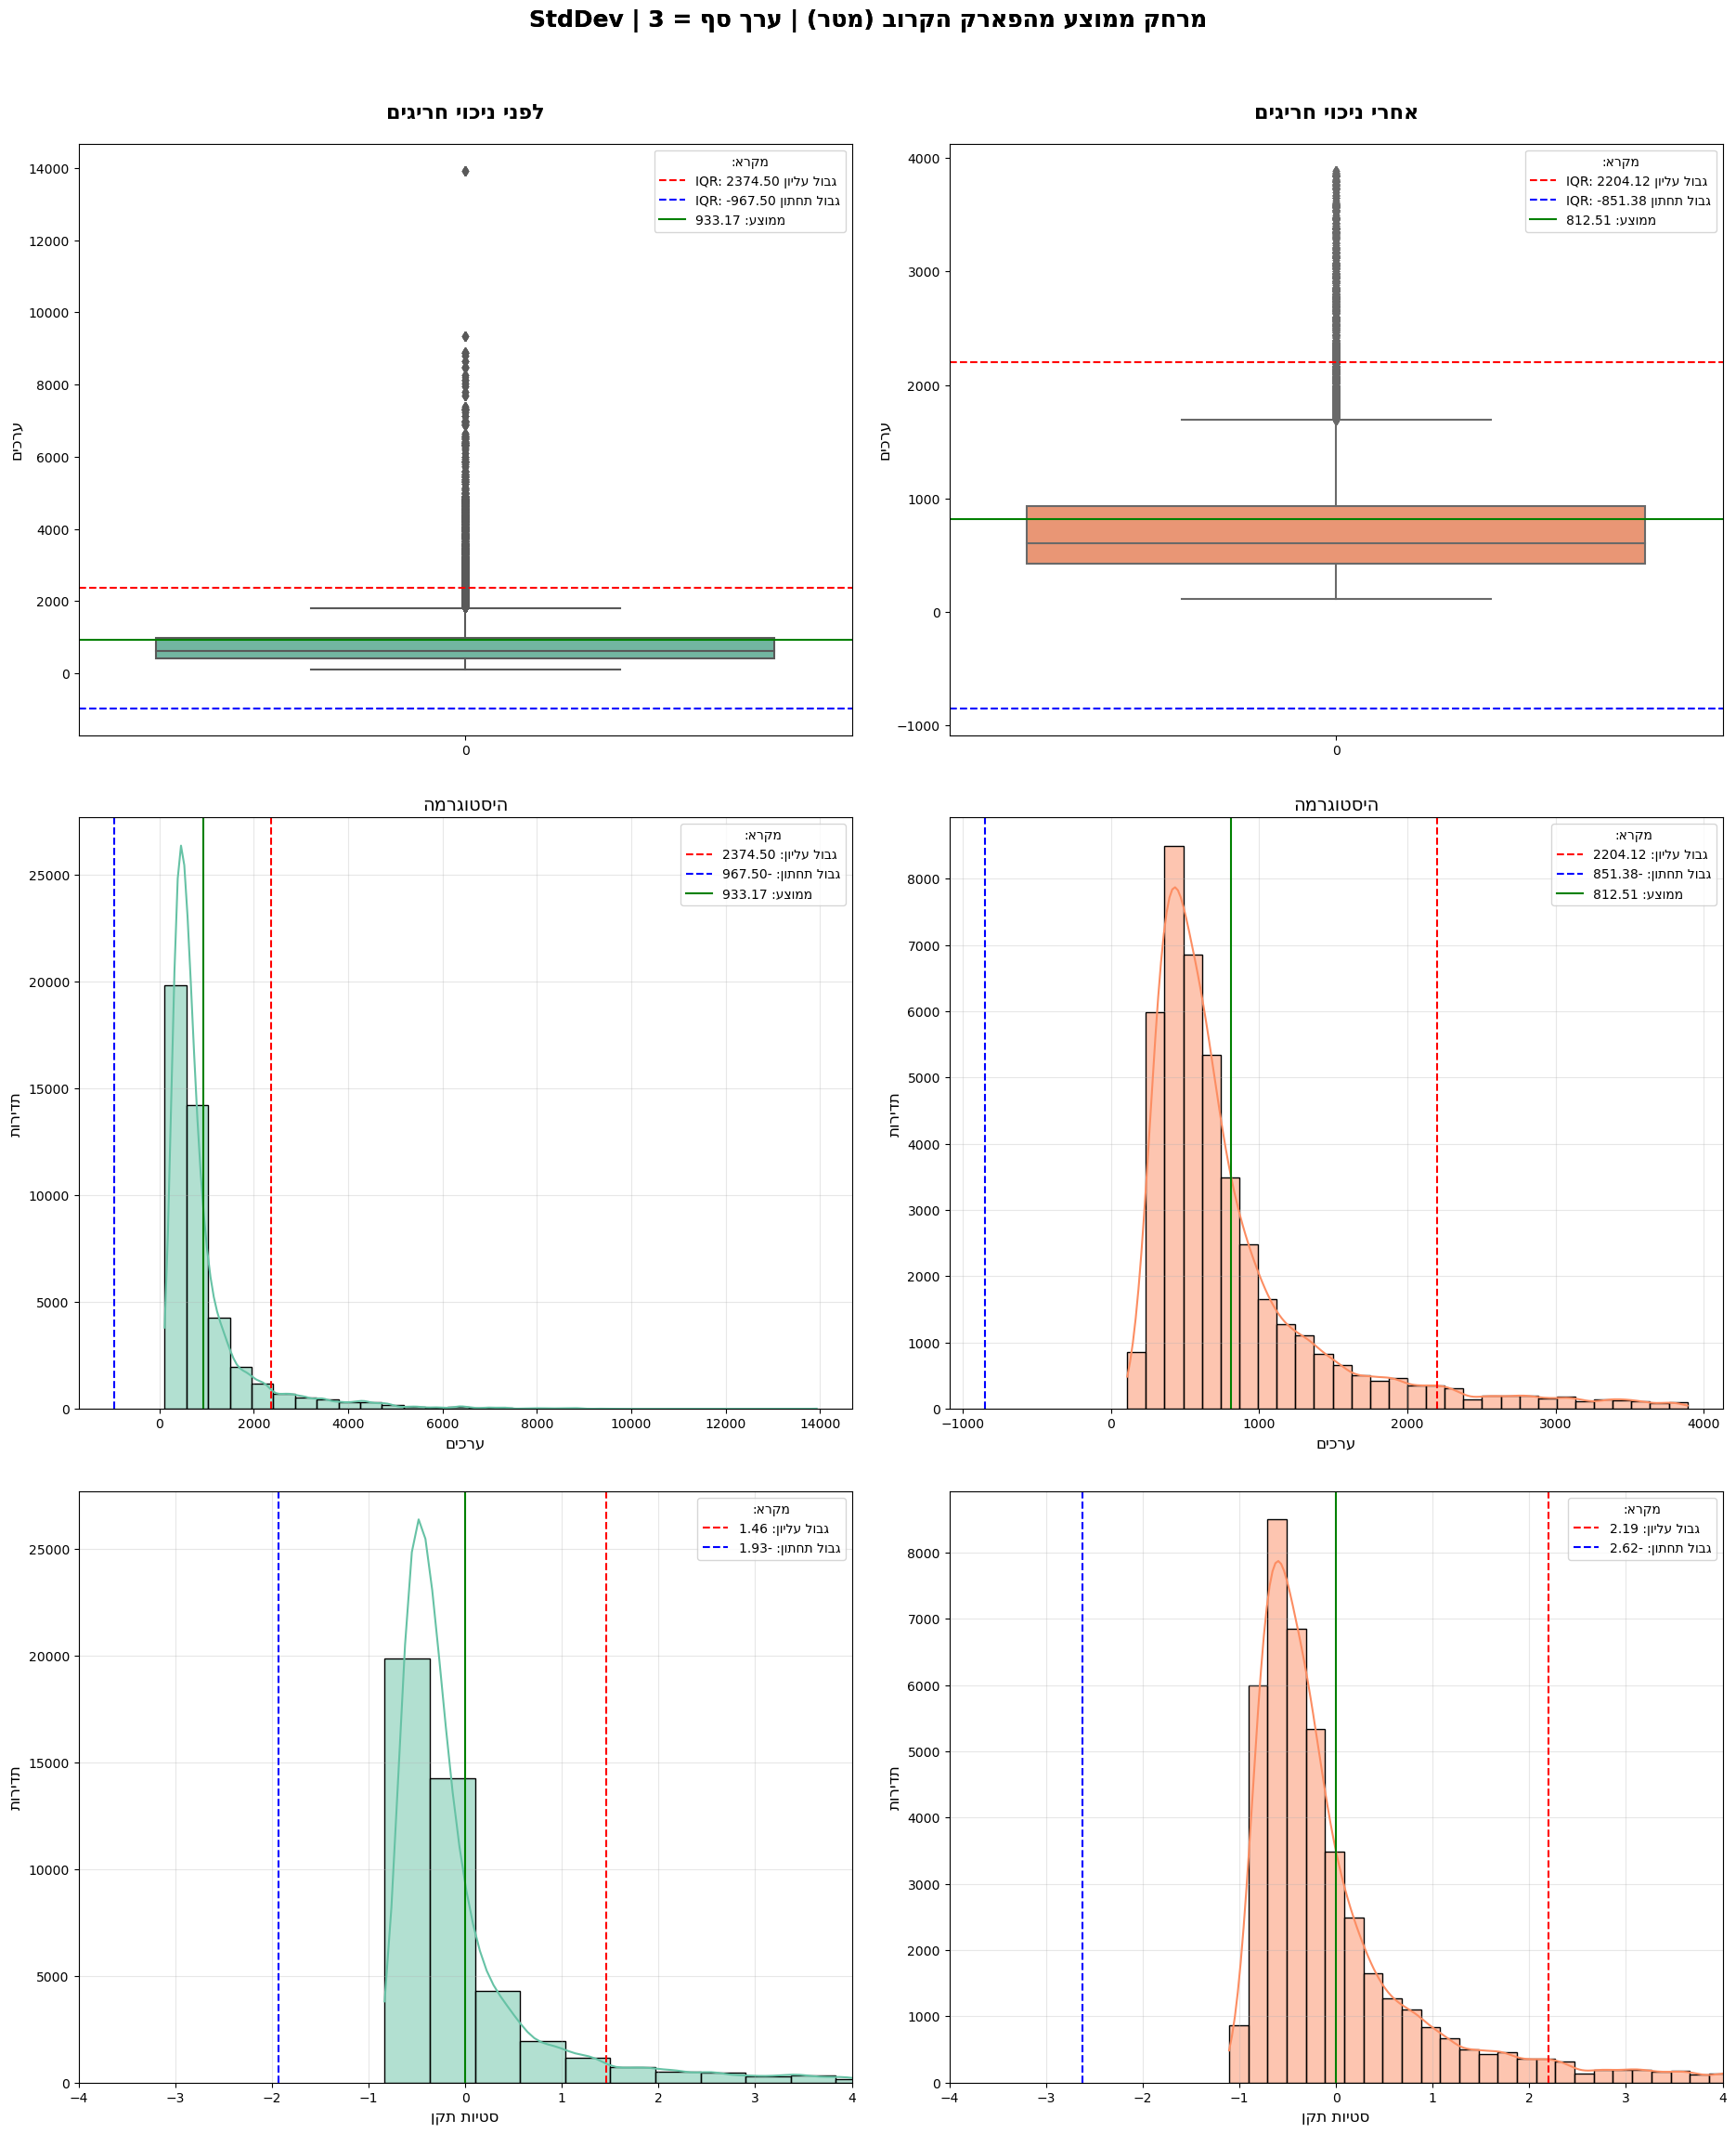

In [235]:
plot_histograms_std_and_regular(top1_befor_STD_df, top1_after_std_df, colomnHebrName)

# מדפיס את כל החריגים

In [ ]:
outliers_df = make_stat_and_detect_outliers(df_after_drop, threshold)

In [11]:
def make_stat_and_detect_outliers(df, thresholds):
    combined_info_iqr = []
    combined_info_std = []
    
    for column in df.columns:
        q1_value = df[column].quantile(0.25)
        q3_value = df[column].quantile(0.75)
        IQR = q3_value - q1_value
        
        mean_value = df[column].mean()
        stdev = df[column].std()
        
        # חישוב גבולות IQR וחריגים עבור IQR
        for threshold in thresholds:
            lower_bound_iqr = q1_value - threshold * IQR
            upper_bound_iqr = q3_value + threshold * IQR
            num_outliers_iqr = ((df[column] < lower_bound_iqr) | (df[column] > upper_bound_iqr)).sum()
            percent_outliers_iqr = num_outliers_iqr / len(df) * 100
            
            combined_info_iqr.append({
                'Column Name': column,
                'Threshold': threshold,
                'Percent of Outliers': percent_outliers_iqr
            })
        
        # חישוב גבולות STD וחריגים עבור STD
        for threshold in thresholds:
            lower_bound_stdev = mean_value - threshold * stdev
            upper_bound_stdev = mean_value + threshold * stdev
            num_outliers_stdev = ((df[column] < lower_bound_stdev) | (df[column] > upper_bound_stdev)).sum()
            percent_outliers_stdev = num_outliers_stdev / len(df) * 100
            
            combined_info_std.append({
                'Column Name': column,
                'Threshold': threshold,
                'Percent of Outliers': percent_outliers_stdev
            })
    
    combined_df_iqr = pd.DataFrame(combined_info_iqr)
    combined_df_std = pd.DataFrame(combined_info_std)
    
    # מציאת המשתנים המובילים ביותר לפי האחוזים של החריגים לכל thresholds
    top_vars_by_iqr = combined_df_iqr.groupby(['Threshold']).apply(lambda x: x.nlargest(3, 'Percent of Outliers')).reset_index(drop=True)
    top_vars_by_std = combined_df_std.groupby(['Threshold']).apply(lambda x: x.nlargest(3, 'Percent of Outliers')).reset_index(drop=True)
    
    return top_vars_by_iqr, top_vars_by_std

# דוגמה לשימוש:
# df = ...

# הגדרת רשימת thresholds לבדיקה
thresholds = [2, 2.5, 3]

# קריאה לפונקציה וקבלת התוצאות
top_vars_by_iqr, top_vars_by_std = make_stat_and_detect_outliers(df_after_drop, thresholds)

In [ ]:
top_vars_by_iqr

In [ ]:
# הגדרת התצוגה למספר מקסימלי של עמודות
pd.set_option('display.max_columns', None)

# הגדרת התצוגה כך שלא יחתוך את התוכן של תאים
pd.set_option('display.max_colwidth', None)

In [ ]:
top_vars_by_std

# כמות השורות כתלות בערך הסף

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def clean_outliers_and_plot(df):
    import numpy as np
    
    thresholds = np.arange(0.5, 10.5, 0.5)

    def Clean_outliers(df, method_outliers, threshold):
        # Select only numeric columns for outlier detection
        numeric_df = df.select_dtypes(include=[np.number])

        if method_outliers == 'IQR':
            Q1 = numeric_df.quantile(0.25)
            Q3 = numeric_df.quantile(0.75)
            IQR = Q3 - Q1
            filter_condition = ~((numeric_df < (Q1 - threshold * IQR)) | (numeric_df > (Q3 + threshold * IQR))).any(axis=1)
        elif method_outliers == 'StdDev':
            mean = numeric_df.mean()
            std_dev = numeric_df.std()
            filter_condition = ~((numeric_df < (mean - threshold * std_dev)) | (numeric_df > (mean + threshold * std_dev))).any(axis=1)
        else:
            raise ValueError("Invalid method. Choose 'IQR' or 'StdDev'.")

        # Filter the original dataframe
        df_clean = df[filter_condition]

        # Calculate the number of outliers removed
        num_outliers_removed = len(df) - len(df_clean)
        num_remaining = len(df_clean)

        return df_clean, num_remaining

    # Initialize lists to store results
    num_remaining_list_iqr = []
    num_remaining_list_stddev = []

    # Iterate over each threshold
    for threshold in thresholds:
        # Call the Clean_outliers function for IQR
        cleaned_df_iqr, num_remaining_iqr = Clean_outliers(df, 'IQR', threshold)
        num_remaining_list_iqr.append(num_remaining_iqr)

        # Call the Clean_outliers function for StdDev
        cleaned_df_stddev, num_remaining_stddev = Clean_outliers(df, 'StdDev', threshold)
        num_remaining_list_stddev.append(num_remaining_stddev)

    # Plotting the effect of thresholds on remaining rows for each method
    plt.figure(figsize=(10, 6))

    # Plot for IQR method
    plt.plot(thresholds, num_remaining_list_iqr, marker='o', linestyle='-', color='blue', label='IQR')

    # Plot for StdDev method
    plt.plot(thresholds, num_remaining_list_stddev, marker='o', linestyle='-', color='green', label='StdDev')

    plt.title(bidialg.get_display('מספר השורות בפאנל כתלות בערך הסף'))
    plt.xlabel(bidialg.get_display('ערך סף'))
    plt.ylabel(bidialg.get_display('מספר השוררות בפאנל'))
    plt.xticks(thresholds)
    plt.grid(True)
    plt.legend(title=bidialg.get_display('שיטת לניקוי חריגים'), loc='upper left')
    plt.tight_layout()
    plt.show()

    return 

# Example usage:
# Assuming df is your DataFrame and thresholds is a list of thresholds
# clean_outliers_and_plot(df)


In [ ]:
clean_outliers_and_plot(df_after_drop)


# במקום מחיקה   null

In [20]:
import pandas as pd
import numpy as np

def Clean_outliers(df, method_outliers, threshold, action='remove'):
    """
    Clean outliers from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    method_outliers (str): The method to use for outlier detection ('IQR' or 'StdDev').
    threshold (float): The threshold for determining outliers.
    action (str): The action to take on outliers ('remove' or 'replace'). Default is 'remove'.
    
    Returns:
    pd.DataFrame: The DataFrame with outliers handled.
    """
    # Select only numeric columns for outlier detection
    numeric_df = df.select_dtypes(include=[np.number])

    if method_outliers == 'IQR':
        Q1 = numeric_df.quantile(0.25)
        Q3 = numeric_df.quantile(0.75)
        IQR = Q3 - Q1
        filter_condition = ~((numeric_df < (Q1 - threshold * IQR)) | (numeric_df > (Q3 + threshold * IQR))).any(axis=1)
        outlier_condition = ((numeric_df < (Q1 - threshold * IQR)) | (numeric_df > (Q3 + threshold * IQR)))
    elif method_outliers == 'StdDev':
        mean = numeric_df.mean()
        std_dev = numeric_df.std()
        filter_condition = ~((numeric_df < (mean - threshold * std_dev)) | (numeric_df > (mean + threshold * std_dev))).any(axis=1)
        outlier_condition = ((numeric_df < (mean - threshold * std_dev)) | (numeric_df > (mean + threshold * std_dev)))
    else:
        raise ValueError("Invalid method. Choose 'IQR' or 'StdDev'.")

    if action == 'remove':
        # Filter the original dataframe to remove outliers
        df_clean = df[filter_condition]
        # Calculate the number of outliers removed
        num_outliers_removed = len(df) - len(df_clean)
        num_remaining = len(df_clean)
        
        print("Clean outliers method: ", method_outliers)
        print("Threshold:", threshold)
        print(f"Number of outliers removed: {num_outliers_removed}")
        print(f"Number of rows in the cleaned dataset: {num_remaining}\n")
        
        return df_clean
    
    elif action == 'replace':
        # Replace outliers with NaN
        df_replaced = df.copy()
        df_replaced[outlier_condition] = np.nan
        # Calculate the number of outliers replaced
        num_outliers_replaced = outlier_condition.sum().sum()
        
        print("Clean outliers method: ", method_outliers)
        print("Threshold:", threshold)
        print(f"Number of outliers replaced with NaN: {num_outliers_replaced}")

        # Calculate the percentage of NaNs in each column
        nan_percentage = (df_replaced.isna().sum() / len(df_replaced)) * 100
        
        # Create a DataFrame with the percentages and sort by percentage
        nan_percentage_df = nan_percentage.reset_index()
        nan_percentage_df.columns = ['Column', 'NaN_Percentage']
        nan_percentage_df = nan_percentage_df.sort_values(by='NaN_Percentage', ascending=False)
        
        print("Percentage of NaNs per column (sorted):")
        print(nan_percentage_df.head(10))
        
        return df_replaced , nan_percentage_df
    
    else:
        raise ValueError("Invalid action. Choose 'remove' or 'replace'.")

# Example usage:
# df_cleaned = Clean_outliers(df, 'IQR', 1.5, action='replace')


In [32]:
method_outliers = 'IQR'
threshold = 2.5
action= 'remove'
remove_df = Clean_outliers(df_after_drop, method_outliers, threshold, action)

Clean outliers method:  IQR
Threshold: 2.5
Number of outliers removed: 21334
Number of rows in the cleaned dataset: 31368



In [36]:
method_outliers = 'StdDev'
threshold = 3
action= 'replace'
replace_df = Clean_outliers(df_after_drop, method_outliers, threshold, action)

Clean outliers method:  StdDev
Threshold: 3
Number of outliers replaced with NaN: 48203
Percentage of NaNs per column (sorted):
                                               Column  NaN_Percentage
80  SMOK005_Underlying_achievement_net_of_exceptio...       17.587568
3                                    COPD003(percent)       17.042996
4                                    COPD004(percent)       16.965201
9                                     AST004(percent)       16.737505
2                                    COPD002(percent)       16.735608
79  SMOK004_Underlying_achievement_net_of_exceptio...       16.680581
8                                     AST003(percent)       16.591401
5                                    COPD005(percent)       16.490835
78  SMOK002_Underlying_achievement_net_of_exceptio...       16.329551
6                                    COPD007(percent)       16.227088


In [177]:
import pandas as pd
import numpy as np

def clean_outliers(df, method_outliers, threshold, action='remove'):
    """
    Clean outliers from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    method_outliers (str): The method to use for outlier detection ('IQR' or 'StdDev').
    threshold (float): The threshold for determining outliers.
    action (str): The action to take on outliers ('remove' or 'replace'). Default is 'remove'.
    
    Returns:
    pd.DataFrame or tuple: The DataFrame with outliers handled, and optionally the percentage of NaNs.
    """
    numeric_df = df.select_dtypes(include=[np.number])
    
    if method_outliers == 'IQR':
        Q1 = numeric_df.quantile(0.25)
        Q3 = numeric_df.quantile(0.75)
        IQR = Q3 - Q1
        outlier_condition = ((numeric_df < (Q1 - threshold * IQR)) | (numeric_df > (Q3 + threshold * IQR)))
    elif method_outliers == 'StdDev':
        mean = numeric_df.mean()
        std_dev = numeric_df.std()
        outlier_condition = ((numeric_df < (mean - threshold * std_dev)) | (numeric_df > (mean + threshold * std_dev)))
    else:
        raise ValueError("Invalid method. Choose 'IQR' or 'StdDev'.")
    
    if action == 'remove':
        df_clean = df[~outlier_condition.any(axis=1)]
        return df_clean
    elif action == 'replace':
        df_replaced = df.copy()
        df_replaced[outlier_condition] = np.nan
        nan_percentage = (df_replaced.isna().sum() / len(df_replaced)) * 100
        return df_replaced, nan_percentage
    else:
        raise ValueError("Invalid action. Choose 'remove' or 'replace'.")

def evaluate_outlier_handling(df, thresholds, method_outliers='IQR'):
    """
    Evaluate outlier handling with different thresholds and both actions (remove and replace).
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    thresholds (list): A list of threshold values to evaluate.
    method_outliers (str): The method to use for outlier detection ('IQR' or 'StdDev').
    
    Returns:
    pd.DataFrame: A DataFrame with the percentage of missing values for each column for each threshold and action.
    """
    results = []
    original_row_count = len(df)
    
    for threshold in thresholds:
        # Evaluate 'remove' action
        df_clean = clean_outliers(df, method_outliers, threshold, 'remove')
        nan_percentage_remove = (df_clean.isna().sum() / len(df_clean)) * 100
        nan_percentage_remove = nan_percentage_remove.reset_index()
        nan_percentage_remove.columns = ['Column', 'NaN_Percentage']
        nan_percentage_remove['Threshold'] = threshold
        nan_percentage_remove['Action'] = 'remove'
        nan_percentage_remove['Row_Count'] = len(df_clean)
        results.append(nan_percentage_remove)
        
        # Evaluate 'replace' action
        df_replaced, nan_percentage_replace = clean_outliers(df, method_outliers, threshold, 'replace')
        nan_percentage_replace = nan_percentage_replace.reset_index()
        nan_percentage_replace.columns = ['Column', 'NaN_Percentage']
        nan_percentage_replace['Threshold'] = threshold
        nan_percentage_replace['Action'] = 'replace'
        nan_percentage_replace['Row_Count'] = original_row_count
        results.append(nan_percentage_replace)
    
    results_df = pd.concat(results, ignore_index=True)
    results_df = results_df.pivot_table(
        index=['Column', 'Threshold'], 
        columns='Action', 
        values=['NaN_Percentage', 'Row_Count']
    ).reset_index()
    
    results_df.columns = ['_'.join(col).strip() for col in results_df.columns.values]
    results_df = results_df.rename(columns={'Column_': 'Column', 'Threshold_': 'Threshold'})
    
    return results_df

In [191]:
# Example usage:
thresholds = [2.5]
results_df = evaluate_outlier_handling(df_after_drop, thresholds, method_outliers='IQR')
results_df
results_df_sorted = results_df.sort_values(by=[('NaN_Percentage_replace')], ascending=[ False])

results_df_sorted.head(5)

,Column,Threshold,NaN_Percentage_remove,NaN_Percentage_replace,Row_Count_remove,Row_Count_replace
51,SMOK005_Underlying_achievement_net_of_exceptio...,2.5,0.007811,9.491518,25606.0,44682.0
8,COPD007(percent),2.5,0.011716,8.954389,25606.0,44682.0
5,COPD003(percent),2.5,0.015621,8.379213,25606.0,44682.0
75,Weighted_ParksOnly_Average_distance_to_nearest...,2.5,0.581895,7.206481,25606.0,44682.0
77,Weighted_ParksOnly_Average_size_of_nearest_Par...,2.5,0.581895,6.774540,25606.0,44682.0


In [193]:
# Example usage:
thresholds = [2.5]
results_df = evaluate_outlier_handling(df_after_drop, thresholds, method_outliers='StdDev')
results_df
results_df_sorted = results_df.sort_values(by=[('NaN_Percentage_replace')], ascending=[ False])

results_df_sorted.head(5)

,Column,Threshold,NaN_Percentage_remove,NaN_Percentage_replace,Row_Count_remove,Row_Count_replace
58,Weighted_Flats_Average_size_of_private_outdoor...,2.5,0.590788,4.191845,27421.0,44682.0
75,Weighted_ParksOnly_Average_distance_to_nearest...,2.5,0.590788,4.176178,27421.0,44682.0
74,Weighted_ParksAndPlayingFields_Number_of_built...,2.5,0.590788,4.026230,27421.0,44682.0
51,SMOK005_Underlying_achievement_net_of_exceptio...,2.5,0.007294,3.726333,27421.0,44682.0
61,Weighted_Houses_Average_size_of_private_outdoo...,2.5,0.590788,3.596527,27421.0,44682.0


# מחיקת ערכים חסרים

In [ ]:
df_after_drop.isnull().sum()

In [ ]:
        nan_percentage = (df_after_drop.isna().sum() / len(df_after_drop)) * 100
        # Create a DataFrame with the percentages and sort by percentage
        nan_percentage_df = nan_percentage.reset_index()
        nan_percentage_df.columns = ['Column', 'NaN_Percentage']
        nan_percentage_df = nan_percentage_df.sort_values(by='NaN_Percentage', ascending=False)
        nan_percentage_df